In [1]:
import sqlite3
import matplotlib as plt
import pandas as pd
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql_query(q,conn)

q = 'SELECT * FROM customer LIMIT 5'
run_query(q)

,customer_id,first_name,last_name,company,address,city,state,country,postal_code,phone,fax,email,support_rep_id
0,1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
1,2,Leonie,Köhler,None,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,+49 0711 2842222,None,leonekohler@surfeu.de,5
2,3,François,Tremblay,None,1498 rue Bélanger,Montréal,QC,Canada,H2G 1A7,+1 (514) 721-4711,None,ftremblay@gmail.com,3
3,4,Bjørn,Hansen,None,Ullevålsveien 14,Oslo,None,Norway,0171,+47 22 44 22 22,None,bjorn.hansen@yahoo.no,4
4,5,František,Wichterlová,JetBrains s.r.o.,Klanova 9/506,Prague,None,Czech Republic,14700,+420 2 4172 5555,+420 2 4172 5555,frantisekw@jetbrains.com,4


In [2]:
def run_command(command):
    with sqlite3.connect('chinook.db') as conn:
            conn.isolation_level = None
            conn.execute(command)

def show_tables():
    query = 'SELECT name, type \
    FROM sqlite_master WHERE type IN ("table","view");'
    return run_query(query)

show_tables()    

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [3]:
query = 'WITH track_genre AS (SELECT t.track_id, g.name FROM \
track t INNER JOIN genre g ON g.genre_id = t.genre_id),\
        \
        itg AS (SELECT tg.name, il.quantity \
        FROM invoice_line il \
        INNER JOIN track_genre tg ON \
        tg.track_id = il.track_id), \
        \
        gt AS (SELECT itg.name genre_name,\
        SUM(itg.quantity) number_of_tracks FROM itg \
        GROUP BY(1) ORDER BY(2) DESC) \
\
SELECT genre_name, number_of_tracks, \
ROUND(CAST(number_of_tracks as Float)/CAST((SELECT SUM(number_of_tracks) FROM gt) as Float),2) percentage \
FROM gt'

run_query(query)

,genre_name,number_of_tracks,percentage
0,Rock,2635,0.55
1,Metal,619,0.13
2,Alternative & Punk,492,0.10
3,Latin,167,0.04
4,R&B/Soul,159,0.03
5,Blues,124,0.03
6,Jazz,121,0.03
7,Alternative,117,0.02
8,Easy Listening,74,0.02
9,Pop,63,0.01


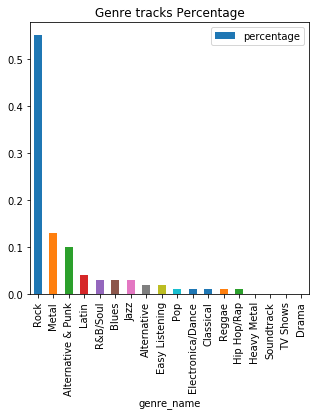

In [4]:
results = run_query(query)

results.plot(x='genre_name', y='percentage', \
             kind='bar', title='Genre tracks Percentage', figsize=(5,5))

###### We can see in the plot that in order of people's preference, we can incorporate the following artist: Red Tone, Slim Jim Bites and Meteor and the Girls. 

In [5]:
query2 = 'WITH ci AS \
          (SELECT c.customer_id, c.support_rep_id vendedor, \
          SUM(i.total) total_purchased\
          FROM invoice i LEFT JOIN customer c \
          ON c.customer_id = i.customer_id \
          GROUP BY(1)) \
SELECT e.first_name||" "||e.last_name Employee, \
       SUM(ci.total_purchased) as total_sold, \
       e.hire_date Fecha_de_ingreso \
       FROM employee e LEFT JOIN ci \
       ON ci.vendedor = e.employee_id \
       GROUP BY(1) ORDER BY(1) DESC \
       '
results2 = run_query(query2).dropna().sort_values(by='total_sold',ascending=False)
results2

,Employee,total_sold,Fecha_de_ingreso
6,Jane Peacock,1731.51,2017-04-01 00:00:00
4,Margaret Park,1584.00,2017-05-03 00:00:00
0,Steve Johnson,1393.92,2017-10-17 00:00:00


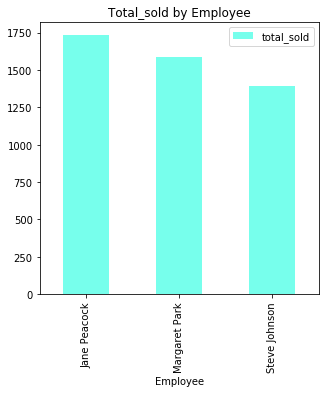

In [6]:
results2.plot(x='Employee', y='total_sold', color=(119/255,255/255,236/255), \
             kind='bar', title='Total_sold by Employee', figsize=(5,5))

In [7]:
def until_today(today_date_tuple,date):
    date_tuple = (int(date[0:4]),int(date[5:7]),int(date[8:10]))
    delta_a = today_date_tuple[0]-date_tuple[0]
    delta_m = today_date_tuple[1]-date_tuple[1]
    delta_d = today_date_tuple[2]-date_tuple[2]
    return delta_a*(12-date_tuple[1]+today_date_tuple[1])

def until_today2(date):
    today_date_tuple = (2018,5,1)
    return until_today(today_date_tuple,date)
    
results2["time_working"] = results2["Fecha_de_ingreso"].apply(until_today2)
results2["sales/month"] = results2["total_sold"]/results2["time_working"]
results2

,Employee,total_sold,Fecha_de_ingreso,time_working,sales/month
6,Jane Peacock,1731.51,2017-04-01 00:00:00,13,133.193077
4,Margaret Park,1584.00,2017-05-03 00:00:00,12,132.000000
0,Steve Johnson,1393.92,2017-10-17 00:00:00,7,199.131429


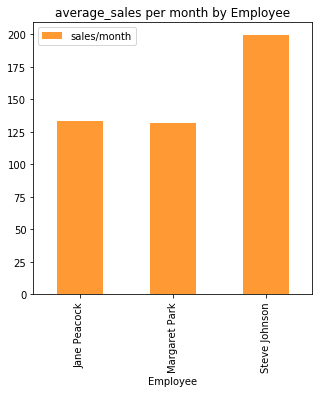

In [8]:
results2.plot(x='Employee', y="sales/month", color=(255/255,153/255,51/255), \
             kind='bar', title='average_sales per month by Employee', figsize=(5,5))

#####  In first instance, we can say that Jane Peacock is the great seller, but if we look at the time they have been working until today (May-2018), the average sales per month shows another picture. Clearly Steve Johnson is the most productive seller with an average of almost 200 sales in a month. 

In [9]:
run_query('SELECT DISTINCT(country) FROM customer')
# THE DISTINCT COUNTRYS IN THE DATABSES OF CUSTOMERS. 

,country
0,Brazil
1,Germany
2,Canada
3,Norway
4,Czech Republic
5,Austria
6,Belgium
7,Denmark
8,USA
9,Portugal


In [10]:
query3 = 'WITH ci AS (SELECT c.country, \
                             c.customer_id, SUM(i.total) total_value, \
                             COUNT(i.invoice_id) total_orders \
                             FROM customer c LEFT JOIN invoice i \
                             ON c.customer_id = i.customer_id \
                             GROUP BY(2)), \
           c123c AS (SELECT ci.country, \
                             COUNT(ci.customer_id) total_customers, \
                             SUM(ci.total_value) total_sales, \
                             SUM(ci.total_value)/COUNT(ci.customer_id) avg_sales_per_customers \
                             FROM ci \
                             GROUP BY(1)), \
            c4c AS (SELECT c.country, SUM(i.total) total, \
            COUNT(i.invoice_id) cant, \
            SUM(i.total)/COUNT(i.invoice_id) avg_order_value \
            FROM customer c LEFT JOIN invoice i \
            ON c.customer_id = i.customer_id \
            GROUP BY(1)), \
unitary_countries AS (SELECT c123c.country, \
           SUM(c123c.total_customers) total_customers, \
           SUM(c123c.total_sales) total_sales, \
           AVG(c123c.avg_sales_per_customers) avg_sales_per_customers, \
           AVG(c4c.avg_order_value) avg_order_value \
           FROM c123c INNER JOIN c4c \
           ON c123c.country = c4c.country \
           WHERE c123c.total_customers = 1 \
           ORDER BY(3)), \
normal_countries AS (SELECT c123c.country, \
           c123c.total_customers, \
           c123c.total_sales, \
           c123c.avg_sales_per_customers, \
           c4c.avg_order_value \
           FROM c123c INNER JOIN c4c \
           ON c123c.country = c4c.country \
           WHERE c123c.total_customers > 1 \
           ORDER BY(3)), \
total_and_others AS (SELECT * FROM normal_countries \
UNION \
SELECT * FROM unitary_countries ORDER BY(total_sales) DESC) \
\
SELECT *, CASE WHEN country = "Sweden" THEN 1 ELSE 0 END as sort FROM total_and_others \
ORDER BY(sort) ASC'       
0
run_query(query3)

,country,total_customers,total_sales,avg_sales_per_customers,avg_order_value,sort
0,USA,13,1040.49,80.037692,7.942672,0
1,Canada,8,535.59,66.948750,7.047237,0
2,Brazil,5,427.68,85.536000,7.011148,0
3,France,5,389.07,77.814000,7.781400,0
4,Germany,4,334.62,83.655000,8.161463,0
5,Czech Republic,2,273.24,136.620000,9.108000,0
6,United Kingdom,3,245.52,81.840000,8.768571,0
7,Portugal,2,185.13,92.565000,6.383793,0
8,India,2,183.15,91.575000,8.721429,0
9,Sweden,15,1094.94,72.996000,7.445071,1


In [28]:
results4 = run_query(query3)
results4.replace('Sweden','Others',inplace=True)

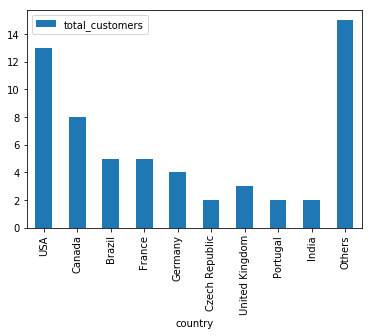

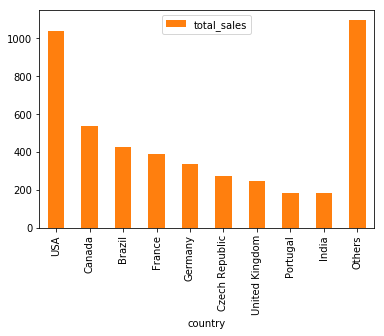

In [59]:
results5 = results4.iloc[:9]
results4.plot(x=results4['country'],y='total_customers', \
             kind='bar',color="C0")
results4.plot(x=results4['country'],y='total_sales', \
             kind='bar',color="C1")

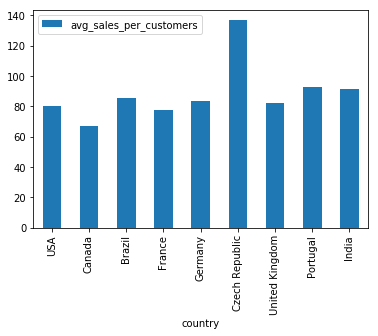

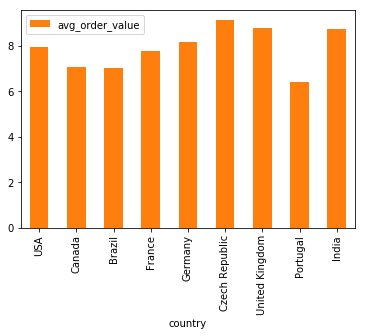

In [58]:
results5.plot(x='country',y='avg_sales_per_customers', \
              kind='bar',color="C0")
results5.plot(x='country',y='avg_order_value', \
              kind='bar',color="C1")

##### FINDINGS
<i>In the graphic above, the amount of customers follows the same trend of the total amount of sales in dollars. 
Also, the rest of the world situated in the column "Others" is an important contributor in both variables. 

<i> In the graphics that follow we discover average of total sales in dollars and the average of the number of orders made per each country (we discard the "Others" column here because has no sense make average calculus in countries with only one customer each). The plot tell us that Czech Republic, United Kindom and India are the most atractive countries for make a marketing effort. Customers here make big orders and a good amount of them. 

In [37]:
c1 = 'DROP VIEW album_track;'
run_command(c1)
c2 = 'DROP VIEW invoice_track'
run_command(c2)

In [38]:
c1 = 'CREATE VIEW album_track AS \
                  SELECT a.album_id, t.track_id \
                  FROM track t LEFT JOIN \
                  album a ON t.album_id = a.album_id \
                  ORDER BY(1)'
run_command(c1)

c2 = 'CREATE VIEW invoice_track AS \
                SELECT i.invoice_id, il.track_id \
                FROM invoice i INNER JOIN invoice_line il \
                ON i.invoice_id = il.invoice_id \
                ORDER BY(1)'
run_command(c2)

In [41]:
query4 = 'SELECT invoice_id FROM invoice ORDER BY(1)'
invoice_index = run_query(query4)
invoice_index
query6 = 'SELECT album_id FROM album ORDER BY(1)'
album_index = run_query(query6)
album_index.head()

,album_id
0,1
1,2
2,3
3,4
4,5


In [42]:
invoice_characteristic = pd.DataFrame([['N','N']],columns=['invoice_id','album_purchased'])

for index in invoice_index["invoice_id"].values:
    for index2 in album_index["album_id"].values:
        query5 = 'WITH invoice_group AS ( \
                  SELECT it.track_id, it.invoice_id FROM invoice_track it \
                  WHERE it.invoice_id = {}), \
            album_group AS (SELECT at.track_id, at.album_id \
            FROM album_track at \
            WHERE at.album_id = {}) \
    SELECT i.invoice_id, CASE \
    WHEN (SELECT ag.track_id FROM album_group ag \
    EXCEPT \
    SELECT ig.track_id FROM invoice_group ig) IS NULL \
    AND (SELECT ig.track_id FROM invoice_group ig \
    EXCEPT \
    SELECT ag.track_id FROM album_group ag) IS NULL \
    THEN 1 ELSE 0 END AS album_purchased FROM \
    invoice i WHERE i.invoice_id={};'.format(index,index2,index)
        if run_query(query5).loc[0,["album_purchased"]].tolist() == [1]:
            break
        else: continue
    
    invoice_characteristic = invoice_characteristic.append(run_query(query5))

invoice_characteristic.head()

,invoice_id,album_purchased
0,N,N
0,1,1
0,2,0
0,3,0
0,4,0


In [43]:
real_invoice_characteristic = invoice_characteristic.iloc[1:]
album_purchased = real_invoice_characteristic["album_purchased"].sum()
number_of_invoices = real_invoice_characteristic.shape[0]

print("compras de álbumes completos: ",album_purchased)
print("cantidad total de compras: ",number_of_invoices)
print("porcentaje de compras de álbumes completos: ",album_purchased/number_of_invoices)

compras de álbumes completos:  114
cantidad total de compras:  614
porcentaje de compras de álbumes completos:  0.18566775244299674


###### As shows the last output, only the 18,56% of the customer's purchases are about complete álbums instead of the 81,43%  that are about individual songs. The new purchasing strategy considered by management is strongly supported by data. 

In [45]:
query7 = 'WITH \
        track_artist AS \
                      (SELECT t.track_id, al_ar.artist_name \
                      FROM track t LEFT JOIN \
                      (SELECT a.name artist_name, \
                      al.album_id FROM album al LEFT JOIN \
                      artist a ON a.artist_id=al.artist_id) \
                      al_ar ON al_ar.album_id=t.album_id \
                      ORDER BY(2)), \
        playlist_name_track AS \
                      (SELECT p.name playlist_name, pt.track_id \
                      FROM playlist_track pt \
                      LEFT JOIN playlist p \
                      ON p.playlist_id=pt.playlist_id \
                      ORDER BY(1)) \
SELECT t_a.artist_name, COUNT(pnt.playlist_name) \
                       FROM playlist_name_track pnt \
                       LEFT JOIN track_artist t_a \
                       ON t_a.track_id = pnt.track_id \
                       GROUP BY(1) ORDER BY(2) DESC;'

run_query(query7).head(30)

,artist_name,COUNT(pnt.playlist_name)
0,Iron Maiden,516
1,U2,333
2,Metallica,296
3,Led Zeppelin,252
4,Deep Purple,226
5,Lost,184
6,Pearl Jam,177
7,Eric Clapton,145
8,Faith No More,145
9,Lenny Kravitz,143


##### Which artist is used in the most playlists? 

<i>Iron Maiden is by far the most used in playlist, the next artist in the top 5 are (in order): U2, Metallica, Led Zeppelin, Deep Purple.  

In [46]:
run_query('WITH tt AS \
          (SELECT COUNT(DISTINCT(track_id)) tracks_purchased, \
(SELECT COUNT(*) FROM track) total_tracks \
FROM invoice_track ORDER BY(1)) \
SELECT tracks_purchased, (total_tracks-tracks_purchased) tracks_not_purchased \
FROM tt;')


,tracks_purchased,tracks_not_purchased
0,1806,1697


##### How many tracks have been purchased vs not purchased?

There are 1806 tracks purchased and 1697 not purchased (the minority).

In [47]:
run_query('SELECT COUNT(*) range_tracks, \
(SELECT COUNT(*) FROM invoice_track) total_tracks_sold, \
(SELECT COUNT(DISTINCT(track_id)) FROM invoice_track) distinct_tracks_sold \
FROM track')

,range_tracks,total_tracks_sold,distinct_tracks_sold
0,3503,4757,1806


#####  Almost the 51% of the range of tracks in the store have been sold. 

In [48]:
results10= run_query('SELECT m.name Media_Type, \
                  m.media_type_id, COUNT(it.invoice_line_id) total_sales\
                  FROM media_type m \
                  INNER JOIN (SELECT t.track_id, t.media_type_id, il.invoice_line_id \
                  FROM track t INNER JOIN invoice_line il \
                  ON il.track_id = t.track_id) it \
                  ON it.media_type_id = m.media_type_id \
                  GROUP BY(Media_Type) ORDER BY(3) DESC')

results10

,Media_Type,media_type_id,total_sales
0,MPEG audio file,1,4259
1,Protected AAC audio file,2,439
2,Purchased AAC audio file,4,35
3,AAC audio file,5,21
4,Protected MPEG-4 video file,3,3


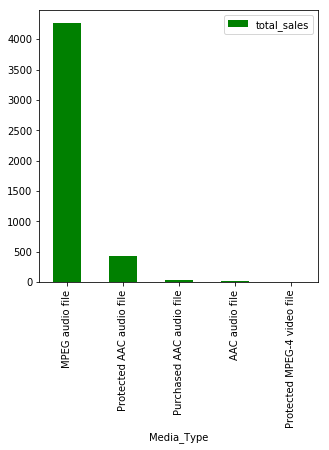

In [49]:
results10.plot(x='Media_Type',y='total_sales', color='g',figsize=(5,5), kind='bar')

###### MPEG is the most popular media type by far.